##### The cell below is for you to keep track of the libraries used and install those libraries quickly
##### Ensure that the proper library names are used and the syntax of `%pip install PACKAGE_NAME` is followed

In [34]:
#%pip install pandas 
#%pip install matplotlib
# add commented pip installation lines for packages used as shown above for ease of testing
# the line should be of the format %pip install PACKAGE_NAME 

## Import Libraries

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# from datetime import date, datetime

filepath = "./data/catB_train.parquet" 

## Exploratory Data Analysis (EDA)

In [36]:
df = pd.read_parquet(filepath)
df["f_purchase_lh"] = df["f_purchase_lh"].fillna(0)
df

,clntnum,race_desc,ctrycode_desc,clttype,stat_flag,min_occ_date,cltdob_fix,cltsex_fix,flg_substandard,flg_is_borderline_standard,...,recency_giclaim,giclaim_cnt_success,recency_giclaim_success,giclaim_cnt_unsuccess,recency_giclaim_unsuccess,flg_gi_claim_29d435_ever,flg_gi_claim_058815_ever,flg_gi_claim_42e115_ever,flg_gi_claim_856320_ever,f_purchase_lh
19550,91b546e924,Chinese,Singapore,P,ACTIVE,2017-10-31,1974-05-09,Female,0.0,0.0,...,NaN,None,None,None,None,None,None,None,None,0.0
4600,896bae548c,Chinese,Singapore,P,ACTIVE,2007-05-23,1979-11-11,Male,0.0,0.0,...,NaN,None,None,None,None,None,None,None,None,0.0
13337,f364439ae6,Others,Singapore,P,ACTIVE,2019-08-31,1976-01-28,Male,0.0,0.0,...,NaN,None,None,None,None,None,None,None,None,0.0
15074,70f319cfe1,Chinese,Singapore,P,ACTIVE,2021-10-18,1976-03-19,Female,0.0,0.0,...,NaN,None,None,None,None,None,None,None,None,0.0
19724,2647a81328,Chinese,Singapore,P,ACTIVE,2018-07-20,1995-07-31,Female,0.0,0.0,...,NaN,None,None,None,None,None,None,None,None,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,3363260248,None,Singapore,P,LAPSED,2016-08-01,1994-05-24,Male,0.0,0.0,...,NaN,None,None,None,None,None,None,None,None,0.0
11964,c3509f0aef,Chinese,Singapore,P,ACTIVE,1990-03-20,1948-12-16,Male,0.0,0.0,...,NaN,None,None,None,None,None,None,None,None,0.0
5390,6e44cfb3e7,Chinese,Singapore,P,ACTIVE,2007-12-31,1967-12-06,Female,0.0,0.0,...,NaN,None,None,None,None,None,None,None,None,0.0
860,dd4e362f9f,Others,Singapore,P,ACTIVE,2007-09-01,1986-04-01,Male,0.0,0.0,...,NaN,None,None,None,None,None,None,None,None,0.0


### Data Cleaning

In [37]:
def clean_data(df):
    df_clean = df.copy(deep=True)

    # fill target column NA with 0
    df_clean["f_purchase_lh"]= df_clean["f_purchase_lh"].fillna(0)

    # encode Singapore customers with True (1), others with 0 (False)
    df_clean['ctrycode_desc'] = (df_clean['ctrycode_desc'] == 'Singapore')

    ## process dates
    # for min_occ_date
    curr_date, min_date = '2024-01-29', min(df_clean['min_occ_date'])
    df_clean['cust_lifetime'] = (pd.to_datetime(curr_date) - pd.to_datetime(df_clean['min_occ_date'].replace('None', min_date))).dt.days/365
    # for cltdob_fix
    df_clean['cust_age'] = (pd.to_datetime(curr_date) - pd.to_datetime(df_clean['cltdob_fix'].replace('None', min_date))).dt.days/365
    # drop columns
    df_clean = df_clean.drop(columns=['min_occ_date', 'cltdob_fix'])

    # convert some flags from int to string (object)
    flag_cols = [col for col in df_clean.columns if 'flg_' == col[:4]] +\
                [col for col in df_clean.columns if 'is_' == col[:3]] +\
                [col for col in df_clean.columns if 'f_' == col[:2]]
    
    for flag_col in flag_cols:
        df_clean[flag_col] = df_clean[flag_col].apply(str).replace('nan', None)

    # replace '>4' with 5 in hh_size_est
    df_clean['hh_size_est'] = df_clean['hh_size_est'].replace('>4', '5')

    # replace incomes
    df_clean['annual_income_est'] = df_clean['annual_income_est'].replace({'E.BELOW30K':0, 
                                                                        'D.30K-60K':30,
                                                                        'C.60K-100K':60,
                                                                        'B.100K-200K':100,
                                                                        'A.ABOVE200K':200})

    # fillna
    fillna_cols = ['hlthclaim_amt', 'giclaim_amt', 'recency_hlthclaim', 'recency_giclaim', 'hlthclaim_cnt_success', 'giclaim_cnt_success']
    for col in fillna_cols:
        df_clean[col] = df_clean[col].fillna(0)

    # average amt per claim
    # df_clean['hlthclaim_avg'] = df_clean['hlthclaim_amt']/(df_clean['hlthclaim_cnt_success'].replace(0,1))
        
    df_clean['f_purchase_lh'] = df_clean['f_purchase_lh'].apply(float).apply(int)
    return df_clean
df_clean = clean_data(df)

In [38]:
col = 'hlthclaim_cnt_success'
# col = 'lapse_ape_grp_caa6ff'
print('Null values:', df[col].isna().sum())
print(df[col].value_counts())

Null values: 16715
2.0      295
1.0      275
4.0      153
6.0       82
3.0       72
        ... 
34.0       1
45.0       1
66.0       1
106.0      1
203.0      1
Name: hlthclaim_cnt_success, Length: 69, dtype: int64


### Data Visualization

<AxesSubplot: xlabel='hh_size', ylabel='Count'>

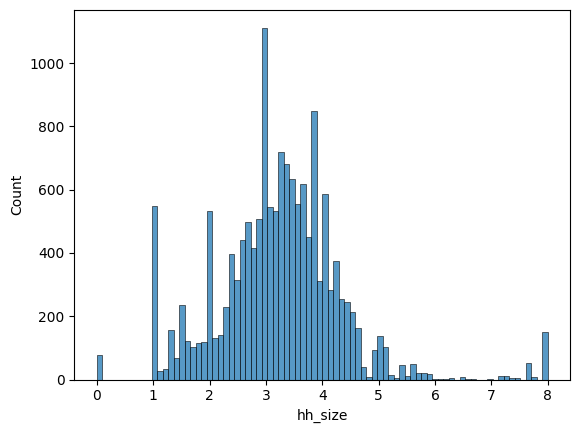

In [39]:
sns.histplot(df['hh_size'])

Text(0.5, 0.98, "No significant demographic difference between those who do/don't purchase")

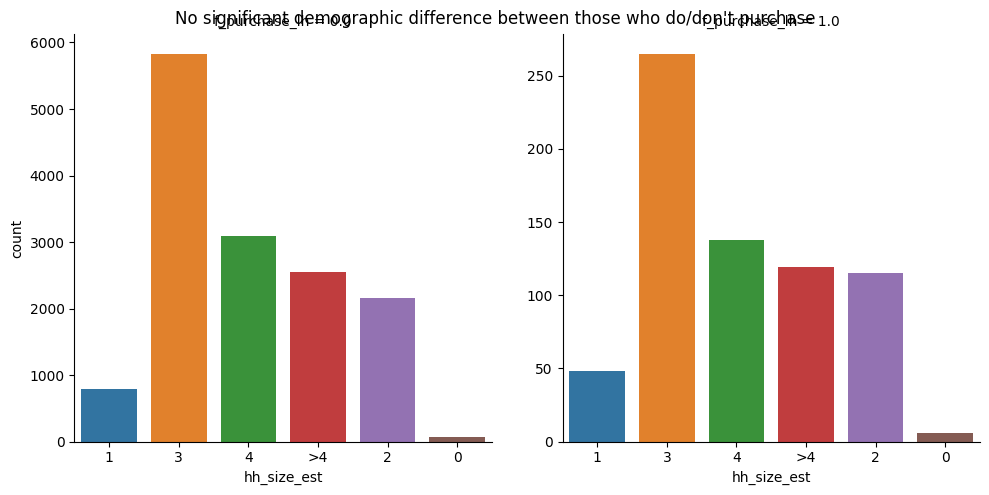

In [40]:
sns.catplot(df, col='f_purchase_lh', x='hh_size_est', kind='count', sharey=False)
plt.suptitle("No significant demographic difference between those who do/don't purchase")

Text(0.5, 0.98, 'Higher income individuals are more likely to purchase in the next 3 months')

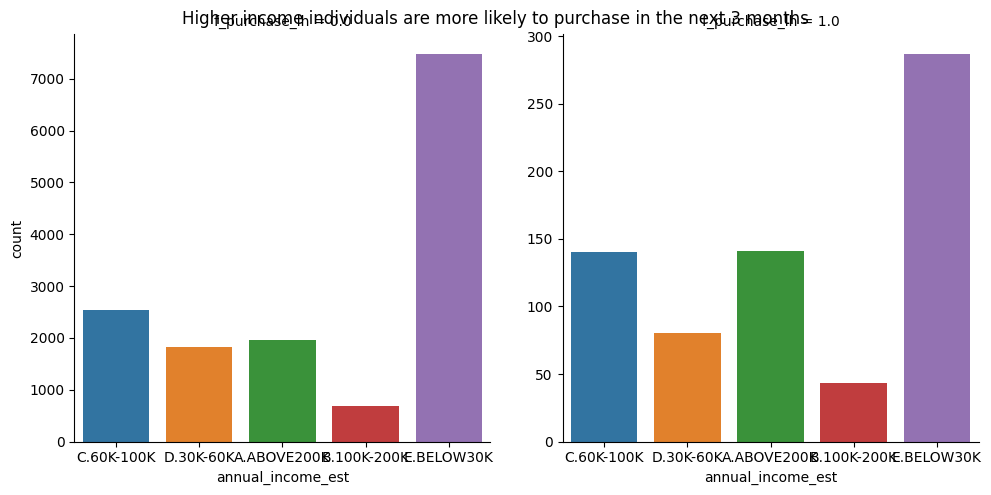

In [41]:
sns.catplot(df, col='f_purchase_lh', x='annual_income_est', kind='count', sharey=False)
plt.suptitle('Higher income individuals are more likely to purchase in the next 3 months')

Text(0.5, 0.98, 'SG/PR are more likely to purchase again in the next 3 months')

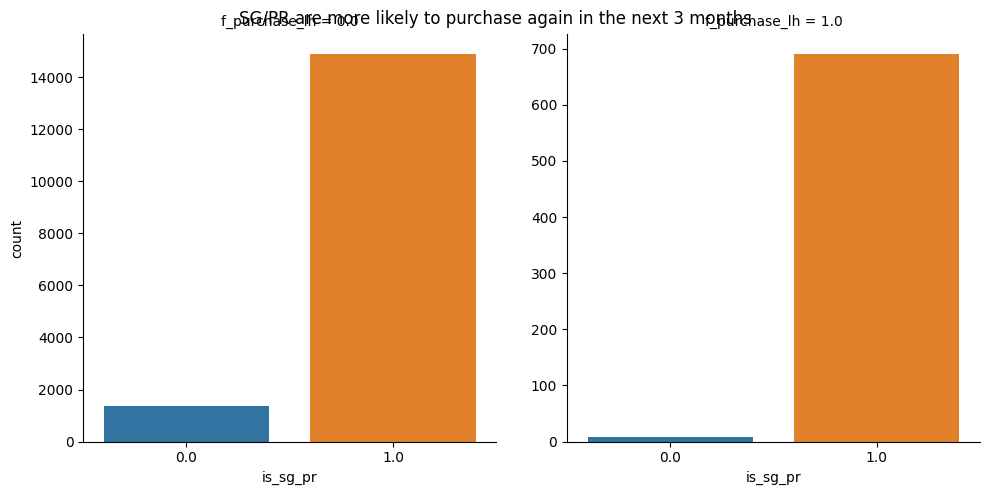

In [42]:
sns.catplot(df, col='f_purchase_lh', x='is_sg_pr', kind='count', sharey=False)
plt.suptitle('SG/PR are more likely to purchase again in the next 3 months')

## Classification Pipeline

In [43]:
# identify numeric and non-numeric columns
numeric_cols = df_clean.select_dtypes(include=["int64", "float64"]).columns
numeric_cols = [col for col in numeric_cols if col != 'f_purchase_lh']
categorical_cols = df_clean.select_dtypes(include=["string", "object"]).columns

In [44]:
X, y = df_clean.drop(columns="f_purchase_lh"), df_clean["f_purchase_lh"]

In [45]:
df_clean["f_purchase_lh"]

19550    0
4600     0
13337    0
15074    0
19724    0
        ..
11284    0
11964    0
5390     0
860      0
15795    0
Name: f_purchase_lh, Length: 17992, dtype: int64

In [46]:
numeric_transformer = Pipeline(
    [
        ('standard_scaler', StandardScaler()),
        ('impute', SimpleImputer(missing_values=np.nan, strategy='median'))
    ]
)

categorical_transformer = Pipeline(
    [
        ('ordinal_encoding', OneHotEncoder(handle_unknown='ignore', drop='first')),
        ('impute', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

preprocessing = ColumnTransformer(
    [
        ('numeric_transformer', numeric_transformer, numeric_cols),
        ('categorical_transformer', categorical_transformer, categorical_cols),
    ],
    remainder = 'drop'
)

In [48]:
clf = Pipeline(
    [
        ('preprocessing', preprocessing),
        ('random_forest', xgb.XGBRFClassifier())
    ]
)

params = {
    # 'random_forest__n_estimators':[100,300],
    # 'random_forest__max_depth':[4,5,6,8,10],
    'random_forest__n_estimators':[1],
    'random_forest__max_depth':[4]
}

grid = GridSearchCV(clf, params, cv=4, scoring='accuracy')
grid.fit(X, y)

c:\Users\Claudeon\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:182: UserWarning: Found unknown categories in columns [0, 26, 27, 33, 34, 36, 37, 38, 39, 41, 42, 43, 44, 45, 48, 49, 50, 51, 52, 53, 55, 57, 58, 59, 63, 64, 66, 67, 68, 69, 71, 73, 74, 77, 78, 80, 86, 87, 88, 92, 93, 95, 96, 97, 98, 100, 101, 102, 103, 104, 107, 108, 109, 110, 111, 112, 114, 116, 117, 118, 120, 121, 123, 124, 125, 134, 137, 138, 139, 141, 142, 144, 145, 146, 149, 152, 153, 154, 155, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 174, 177, 178, 180, 182, 183, 184, 185, 186, 187, 188, 190, 191, 192, 193, 194, 195, 196, 205, 208, 209, 210, 211, 238, 239, 241, 242, 244, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 268, 271] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Claudeon\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessin

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('numeric_transformer',
                                                                         Pipeline(steps=[('standard_scaler',
                                                                                          StandardScaler()),
                                                                                         ('impute',
                                                                                          SimpleImputer(strategy='median'))]),
                                                                         ['hh_size',
                                                                          'annual_income_est',
                                                                          'n_months_last_bought_products',
                                                                          'recency_lapse',
                                                                          'recency_cancel',
                                                                          'tot_inforce_pols',
                                                                          'tot_cancel_pols',
                                                                          'a...
                                                        max_cat_to_onehot=None,
                                                        max_delta_step=None,
                                                        max_depth=None,
                                                        max_leaves=None,
                                                        min_child_weight=None,
                                                        missing=nan,
                                                        monotone_constraints=None,
                                                        n_estimators=100,
                                                        n_jobs=None,
                                                        num_parallel_tree=None,
                                                        objective='binary:logistic',
                                                        predictor=None,
                                                        random_state=None,
                                                        reg_alpha=None, ...))]),
             param_grid={'random_forest__max_depth': [4],
                         'random_forest__n_estimators': [1]},
             scoring='accuracy')

In [53]:
grid.predict(X)

array([0, 0, 0, ..., 0, 0, 0])

## The cell below is **NOT** to be removed
##### The function is to be amended so that it accepts the given input (dataframe) and returns the required output (list). 
##### It is recommended to test the function out prior to submission
-------------------------------------------------------------------------------------------------------------------------------
##### The hidden_data parsed into the function below will have the same layout columns wise as the dataset *SENT* to you
##### Thus, ensure that steps taken to modify the initial dataset to fit into the model are also carried out in the function below

In [58]:
def testing_hidden_data(hidden_data: pd.DataFrame) -> list:
    '''DO NOT REMOVE THIS FUNCTION.

The function accepts a dataframe as input and return an iterable (list)
of binary classes as output.

The function should be coded to test on hidden data
and should include any preprocessing functions needed for your model to perform. 
    
All relevant code MUST be included in this function.'''
    def clean_data(df):
        df_clean = df.copy(deep=True)

        # encode Singapore customers with True (1), others with 0 (False)
        df_clean['ctrycode_desc'] = (df_clean['ctrycode_desc'] == 'Singapore')

        ## process dates
        # for min_occ_date
        curr_date, min_date = '2024-01-29', min(df_clean['min_occ_date'])
        df_clean['cust_lifetime'] = (pd.to_datetime(curr_date) - pd.to_datetime(df_clean['min_occ_date'].replace('None', min_date))).dt.days/365
        # for cltdob_fix
        df_clean['cust_age'] = (pd.to_datetime(curr_date) - pd.to_datetime(df_clean['cltdob_fix'].replace('None', min_date))).dt.days/365
        # drop columns
        df_clean = df_clean.drop(columns=['min_occ_date', 'cltdob_fix'])

        # convert some flags from int to string (object)
        flag_cols = [col for col in df_clean.columns if 'flg_' == col[:4]] +\
                    [col for col in df_clean.columns if 'is_' == col[:3]] +\
                    [col for col in df_clean.columns if 'f_' == col[:2]]
        
        for flag_col in flag_cols:
            df_clean[flag_col] = df_clean[flag_col].apply(str).replace('nan', None)

        # replace '>4' with 5 in hh_size_est
        df_clean['hh_size_est'] = df_clean['hh_size_est'].replace('>4', '5')

        # replace incomes
        df_clean['annual_income_est'] = df_clean['annual_income_est'].replace({'E.BELOW30K':0, 
                                                                            'D.30K-60K':30,
                                                                            'C.60K-100K':60,
                                                                            'B.100K-200K':100,
                                                                            'A.ABOVE200K':200})

        # fillna
        fillna_cols = ['hlthclaim_amt', 'giclaim_amt', 'recency_hlthclaim', 'recency_giclaim', 'hlthclaim_cnt_success', 'giclaim_cnt_success']
        for col in fillna_cols:
            df_clean[col] = df_clean[col].fillna(0)

        return df_clean
    df_clean = clean_data(hidden_data)
    
    result = list(grid.predict(df_clean))
    return result

##### Cell to check testing_hidden_data function

In [69]:
# This cell should output a list of predictions.
test_df = pd.read_parquet(filepath)
test_df = test_df.drop(columns=["f_purchase_lh"])
print(testing_hidden_data(test_df))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

### Please have the filename renamed and ensure that it can be run with the requirements above being met. All the best!